In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt


'''
Author: Georgie Nahass
Class: CS415
'''
''' 
get sift features for every patch
image comes in, gets split into patch, sift descriptors (if any) computed for each past and stored in dict--> append to list --> return
'''
def extract_sift_features(image, patch_size=100, stride=100, black_threshold=0.9):
    sift = cv2.SIFT_create()
    h, w = image.shape[:2]
    patch_data = []

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            # plt.imshow(patch)
            # plt.show()
            keypoints, patch_descriptors = sift.detectAndCompute(patch, None)
            img=cv2.drawKeypoints(patch,keypoints,patch,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            # plt.imshow(img)
            # plt.show()
            if patch_descriptors is None:# or background is True:
                patch_info = {
                'x': x,
                'y': y,
                'descriptors': None,
                'num_descriptors': 0   
                }
                patch_data.append(patch_info)

            else:
      
                    
                patch_info = {
                    'x': x,
                    'y': y,
                    'descriptors': patch_descriptors,
                    'num_descriptors': len(patch_descriptors)
                }
                patch_data.append(patch_info)
       
           
    return patch_data




In [2]:
''' 
Determine disease or not
'''
def get_label_from_filename(filename):
    return int(filename.split('.')[0][-1])

''' 
builds list of image information and sift descriptors for every patch
for every image, makes dict of image name, label, and descriptors (which is a list of dicts for every patch). this list gets stored in a list
'''
def process_images(directory, num_images=662):
    files = [file for file in os.listdir(directory) if file.endswith(('.png', '.jpg', '.jpeg'))]
    image_data = []

    for file in files[:num_images]:  # Process only the first 20 images
        image_path = os.path.join(directory, file)
        image = cv2.imread(image_path)
        label = get_label_from_filename(file)

        # Apply SIFT feature extraction
        patch_descriptors = extract_sift_features(image)

        # Store data
        image_info = {
            'filename': file,
            'label': label,
            'descriptors': patch_descriptors
        }
        image_data.append(image_info)

    # Return or save the image_data for further processing
    return image_data

# Specify directory and call the function
directory = 'contrast_then_sam'
all_image_data = process_images(directory)

In [3]:
''' 
Very important function to reshape the data structure. Instead of having a list of dicts per image, we want a list of patches
Every item in 'patch_data_lists' is a dict of a specific patch for every image.
So if there are 25 patches, patch_data_lists is len 25, and each sublist is the number of images
'''

def reshape_data(image_data, num_patches=25):
    patch_data_lists = [[] for _ in range(num_patches)]

    for image_info in image_data:
        label = image_info['label']
        for patch_info in image_info['descriptors']:
            patch_idx = get_patch_index(patch_info['x'], patch_info['y'], patch_size=100, image_size=500)
            patch_data = {
                'patch_coords': (patch_info['x'], patch_info['y']),
                'filename': image_info['filename'],
                'label': label,
                'sift_descriptors': patch_info['descriptors']
            }
            patch_data_lists[patch_idx].append(patch_data)

    return patch_data_lists

''' 
gets index of patch in grid
0 1 2 3  4  5 
6 7 8 9 10 11
....
...
'''
def get_patch_index(x, y, patch_size, image_size):
    # Assuming a square grid of patches
    row = y // patch_size
    col = x // patch_size
    num_patches_per_row = image_size // patch_size
    return row * num_patches_per_row + col

# Reshape the data
reshaped_data = reshape_data(all_image_data)

print(len(reshaped_data))

25


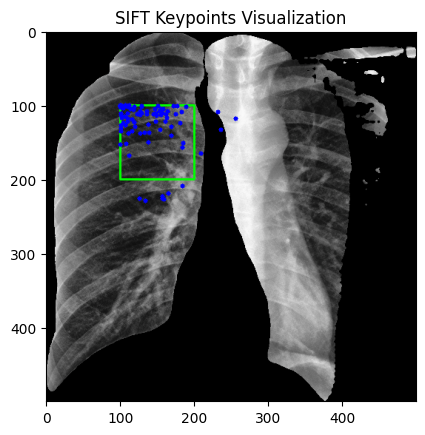

In [4]:
import cv2
import matplotlib.pyplot as plt

def plot_sift_descriptors_for_specific_patch(image, patch_data, patch_index, filename, patch_size=100):
    """
    Plots SIFT keypoints for a specific patch in a specific image.

    :param image: The original image.
    :param patch_data: A list of lists, each containing patch information for all images.
    :param patch_index: The index of the patch to visualize.
    :param filename: The filename of the specific image to visualize.
    :param patch_size: Size of each patch.
    """
    # Filter the data for the specific patch and filename
    specific_patch_data = [patch for patch in patch_data[patch_index] if patch['filename'] == filename]

    if not specific_patch_data:
        print("No data found for the specified patch and image.")
        return

    # Create a copy of the image to draw on
    image_to_draw = image.copy()

    # Iterate over each descriptor in the specific patch
    for patch_info in specific_patch_data:
        x, y = patch_info['patch_coords']

        # Draw a rectangle around the patch
        cv2.rectangle(image_to_draw, (x, y), (x + patch_size, y + patch_size), (0, 255, 0), 2)

        # Draw each keypoint in the patch
        for keypoint in patch_info['sift_descriptors']:
            # Convert keypoint location to coordinates on the original image
            kp_x, kp_y = int(keypoint[0] + x), int(keypoint[1] + y)
            cv2.circle(image_to_draw, (kp_x, kp_y), 3, (255, 0, 0), -1)

    # Display the image
    plt.imshow(cv2.cvtColor(image_to_draw, cv2.COLOR_BGR2RGB))
    plt.title("SIFT Keypoints Visualization")
    plt.show()

    
# Load one of the original images you want to visualize
image = cv2.imread('contrast_then_sam/lungs_CHNCXR_0210_0.png')
patch_index = 6  # for the top-left patch
# Assuming you know the filename of the image you want to visualize
filename_to_visualize = 'lungs_CHNCXR_0210_0.png'

# Extract patch data for the specific image
# specific_image_patch_data = [patch for patch in reshaped_data if patch['filename'] == filename_to_visualize]

# Plot the SIFT descriptors for this specific image
plot_sift_descriptors_for_specific_patch(image, reshaped_data, patch_index, filename_to_visualize)



In [5]:

def split_patch_data(reshaped_data, train_ratio=0.8):
    patch_based_split_data = {}

    num_images = len(reshaped_data[0])
    indices = np.random.permutation(num_images)
    split = int(num_images * train_ratio)
#     # get the proper indices for train and test set
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    for patch_idx, patch_list in enumerate(reshaped_data):
        train_data, train_labels, train_patch_coords, train_filenames = [], [], [], []
        test_data, test_labels, test_patch_coords, test_filenames = [], [], [], []

        for idx in train_indices:
            item = patch_list[idx]
            train_data.append(item['sift_descriptors'])
            train_labels.append(item['label'])
            train_patch_coords.append(item['patch_coords'])
            train_filenames.append(item['filename'])

        for idx in test_indices:
            item = patch_list[idx]
            test_data.append(item['sift_descriptors'])
            test_labels.append(item['label'])
            test_patch_coords.append(item['patch_coords'])
            test_filenames.append(item['filename'])

        patch_based_split_data[patch_idx] = {
            'train': train_data,
            'train_labels': train_labels,
            'train_patch_coords': train_patch_coords,
            'train_filenames': train_filenames,
            'test': test_data,
            'test_labels': test_labels,
            'test_patch_coords': test_patch_coords,
            'test_filenames': test_filenames
        }

    return patch_based_split_data

patch_based_split_data = split_patch_data(reshaped_data)


In [6]:
def prepare_patch_data_for_ml(patch_based_data):

    for patch_index, patch in patch_based_data.items():
        
        training_stacked = []
        training_labels_stacked = []

        non_none_patches_train = []
        non_none_patches_train_labels = []

        non_none_patches_test = []
        non_none_patches_test_labels = []
        
        # Stack valid descriptors and labels for training
        for desc in patch['train']:
            if desc is not None:
                training_stacked.extend(desc)
                non_none_patches_train.append(desc)
                
        for idx, label in enumerate(patch['train_labels']):
            if patch['train'][idx] is not None:
                training_labels_stacked.extend([label] * len(patch['train'][idx]))
                non_none_patches_train_labels.append(label)

        for desc in patch['test']:
            if desc is not None:
                non_none_patches_test.append(desc)
                
        for idx, label in enumerate(patch['test_labels']):
            if patch['test'][idx] is not None:
                non_none_patches_test_labels.append(label)
        
        patch_based_data[patch_index]['training_stacked'] = training_stacked
        patch_based_data[patch_index]['training_labels_stacked'] = training_labels_stacked

        patch_based_data[patch_index]['train'] = non_none_patches_train
        patch_based_data[patch_index]['train_labels'] = non_none_patches_train_labels

        patch_based_data[patch_index]['test'] = non_none_patches_test
        patch_based_data[patch_index]['test_labels'] = non_none_patches_test_labels


    
        # patch_based_data[patch_index]['testing_stacked'] = testing_stacked
        # patch_based_data[patch_index]['testing_labels_stacked'] = testing_labels_stacked
    return patch_based_data

extended_data = prepare_patch_data_for_ml(patch_based_split_data)


In [7]:
def get_valid_patches(data_dict, len_thresh = 150):
    valid_data_dict = {}
    for k,v in extended_data.items():
        if (len(extended_data[k]['training_stacked'])) > len_thresh:
            valid_data_dict[k] = v
    return valid_data_dict

valid_data = get_valid_patches(extended_data)

In [8]:
# check to make sure we got rid of all of the None descriptors in train and testing
for patch_index, patch in valid_data.items():
    for desc in patch['train']:
        if desc is None:
            print('found')

# for patch_index, patch in valid_data.items():
#     for k,v in patch.items():
#         print(patch['train_labels'])


In [9]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


def get_metrics(true_labels, predicted_labels, predicted_probs):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1_scored = f1_score(true_labels, predicted_labels)
    tn, fp, _, _ = confusion_matrix(true_labels, predicted_labels).ravel()
    specificity = tn / (tn + fp)
    auroc_score = roc_auc_score(true_labels, predicted_probs)

    return precision, recall, accuracy, f1_scored, specificity, auroc_score

def train_and_evaluate_model(X_train, X_test, y_train, y_test, performance_metrics, patch_coords):
    model = SVC(kernel='rbf', probability=True)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predicted_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    precision, recall, accuracy, f1_scored, specificity, auroc_score = get_metrics(y_test, predictions, predicted_probs)

    performance_metrics[patch_coords[0]] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_scored,
        'specificity': specificity,
        'auroc_score': auroc_score
    }

    return model

In [10]:
from sklearn.cluster import KMeans
import numpy as np

def bag_of_words(k, kmeans, patch_data):
    histograms = np.zeros((len(patch_data), k))
    for i, descriptors in enumerate(patch_data):
        if len(descriptors) > 0:
            visual_word_indices = kmeans.predict(descriptors)  # Descriptors should already be a NumPy array
            for idx in visual_word_indices:
                histograms[i, idx] += 1

    histograms = histograms / np.linalg.norm(histograms, axis=1, keepdims=True)
    return histograms

def engine(patch_data, bow=True):
    trained_models = {}
    performance_metrics = {}
    for patch_index, patch in patch_data.items():
        n = len(patch['training_stacked'])
        k_list = [20]
        for k in k_list:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
            kmeans.fit(np.array(patch['training_stacked']))
            if bow:
                train_histograms = bag_of_words(k, kmeans, patch['train'])
                test_histograms = bag_of_words(k, kmeans, patch['test'])
    
                trained_svm = train_and_evaluate_model(train_histograms, test_histograms, patch['train_labels'], patch['test_labels'], performance_metrics, patch['train_patch_coords'])
                trained_models[patch['train_patch_coords'][0]] = trained_svm

    return performance_metrics, trained_models

results, models = engine(valid_data)


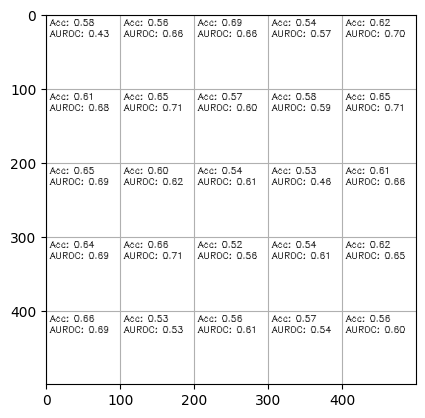

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a blank 500x500 white image
image = np.zeros((500, 500, 3), np.uint8)
image.fill(255)  # Make the background white for better visibility

# Assuming each patch is of size 100x100
patch_size = 100

#

for y in range(0, 500, patch_size):
    for x in range(0, 500, patch_size):
        # Fetch accuracy and AUROC for each patch
        patch_coords = (x, y)
        if patch_coords in results:
            accuracy = results[patch_coords]['accuracy']
            auroc_score = results[patch_coords]['auroc_score']
            accuracy_text = f"Acc: {accuracy:.2f}"
            auroc_text = f"AUROC: {auroc_score:.2f}"
        else:
            accuracy_text = "N/A"
            auroc_text = ""

        # Calculate text position for accuracy (slightly indented from top-left of each patch)
        accuracy_text_position = (x + 5, y + 15)

        # Calculate text position for AUROC (below accuracy)
        auroc_text_position = (x + 5, y + 30)

        # Put the accuracy text on the image
        cv2.putText(image, accuracy_text, accuracy_text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

        # Put the AUROC text on the image
        cv2.putText(image, auroc_text, auroc_text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis(False)
plt.grid(True)
plt.show()


In [12]:
print(results)

{(0, 0): {'accuracy': 0.5825242718446602, 'precision': 0.5542168674698795, 'recall': 0.8846153846153846, 'f1_score': 0.6814814814814815, 'specificity': 0.27450980392156865, 'auroc_score': 0.430052790346908}, (100, 0): {'accuracy': 0.556390977443609, 'precision': 0.5324675324675324, 'recall': 0.640625, 'f1_score': 0.5815602836879432, 'specificity': 0.4782608695652174, 'auroc_score': 0.6623641304347826}, (200, 0): {'accuracy': 0.6929133858267716, 'precision': 0.6463414634146342, 'recall': 0.8412698412698413, 'f1_score': 0.7310344827586207, 'specificity': 0.546875, 'auroc_score': 0.6625744047619048}, (300, 0): {'accuracy': 0.5413533834586466, 'precision': 0.5223880597014925, 'recall': 0.546875, 'f1_score': 0.5343511450381679, 'specificity': 0.5362318840579711, 'auroc_score': 0.5657835144927538}, (400, 0): {'accuracy': 0.625, 'precision': 0.589041095890411, 'recall': 0.7049180327868853, 'f1_score': 0.6417910447761194, 'specificity': 0.5522388059701493, 'auroc_score': 0.6995351113286028}, (